# Importing Libraries

In [89]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# Importing dataset

In [90]:
df = pd.read_csv("./insurance.txt")
df.drop(['children'], axis = 1, inplace = True)
df.head(10)

age     bmi      charges
0   19  27.900  16884.92400
1   18  33.770   1725.55230
2   28  33.000   4449.46200
3   33  22.705  21984.47061
4   32  28.880   3866.85520
5   31  25.740   3756.62160
6   46  33.440   8240.58960
7   37  27.740   7281.50560
8   37  29.830   6406.41070
9   60  25.840  28923.13692

# Shuffling and Preprocessing

In [91]:
df = df.sample(frac = 1)
df = df.reset_index(drop = True)
df.head(10)

age     bmi      charges
0   19  17.800   1727.78500
1   37  30.800   6313.75900
2   30  44.220   4266.16580
3   46  34.600  41661.60200
4   45  22.895  21098.55405
5   38  38.390  41949.24410
6   49  25.840  23807.24060
7   46  43.890   8944.11510
8   35  26.125   5227.98875
9   18  33.535  34617.84065

In [92]:
X = np.array(df.drop(['charges'], axis = 1))
X

array([[19.   , 17.8  ],
       [37.   , 30.8  ],
       [30.   , 44.22 ],
       ...,
       [29.   , 27.94 ],
       [22.   , 37.62 ],
       [24.   , 29.925]])

# Preprocessing and Generating coefficients array

In [93]:
polynomial_coefficients = []
for i in range(1, 11):
    poly = PolynomialFeatures(i)
    data = poly.fit_transform(X)
    polynomial_coefficients.append(np.array(data))

In [94]:
def standardise(x, mean, std):
    return (x-mean)/std

In [95]:
def standardising_columns(df):
    for i,column in enumerate(df.T):
        mn = column.mean()
        stdev = column.std()
        column = standardise(column, mn, stdev)
        df[:, i] = column
    df[:, 0] =  1 # bias term
    return df

In [96]:
for i in range(10):
    polynomial_coefficients[i] = standardising_columns(polynomial_coefficients[i])

<ipython-input-94-384af29ed020>:2: RuntimeWarning: invalid value encountered in true_divide
  return (x-mean)/std


## Standardising target

In [97]:
target_mean = df.mean()['charges']
target_variance = df.std()['charges']
df['charges']  = df['charges'].apply(lambda x : standardise(x,target_mean,target_variance)) 
y = np.array((df['charges'])).reshape(len(df), 1)

In [98]:
train_set_size = int(0.7 * len(df)) # 70% training
val_set_size = int(0.2 * len(df)) # 20% validation
y_train = y[ : train_set_size]
y_val =  y[train_set_size : train_set_size+val_set_size]
y_test = y[train_set_size+val_set_size : ]

# Useful tools

In [99]:
def loss_function(w,X,y):
    return (0.5) * (np.sum((np.dot(X,w) - y)**2))

In [100]:
def stoc_grad_descent(w,X,y,eta,print_flag,reg,l_value):
    loss_values = []
    for epoch in range(10): # 10 passes through the dataset
        for i in range(len(X)):
            if print_flag == True:
                if i%1000 == 0:
                    print(loss_function(w,X,y))
            item = X[i]
            output = y[i]
            if i%50 == 0:
                loss_values.append(loss_function(w,X,y))
            A = (item.transpose()).reshape(w.shape[0],1)
            B = (item.dot(w) - output).reshape(1,1)
            if reg == "l1":
                dw = A.dot(B) + (l_value*np.sign(w))*(1/len(X))
                dw[0] = dw[0] - (l_value*np.sign(w[0]))*(1/len(X))
            elif reg == "l2":
                dw = A.dot(B) + (l_value*2*w)*(1/len(X))
                dw[0] = dw[0] - (l_value*2*w[0])*(1/len(X))
            elif reg == "simple":
                dw = A.dot(B)
            w = w - (eta*dw)
    return w,loss_values

In [101]:
def prediction(parameters,X_test):
    return np.dot(X_test,parameters)

In [102]:
def RMSE(y_true,y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

# Polynomial regression w/o regularization

In [103]:
weights_wo_regu = []
train_errors = []
val_errors = []
test_errors = []
train_RMSE = []
val_RMSE = []
test_RMSE = []

# For each degree
for i in range(10):
    w = np.zeros((polynomial_coefficients[i].shape[1],1))
    X_train = polynomial_coefficients[i][:train_set_size]
    X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
    X_test = polynomial_coefficients[i][train_set_size + val_set_size:]
    print("Polynomial Degree =", (i+1))
    print("Training error every 1,000 iterations: ")
    weights,error = stoc_grad_descent(w,X_train,y_train,0.0001,print_flag = True,reg = "simple",l_value = 0)
    # Appending errors
    train_errors.append(loss_function(weights,X_train,y_train))
    val_errors.append(loss_function(weights,X_val,y_val))
    test_errors.append(loss_function(weights,X_test,y_test))
    # Predictions
    y_train_pred = prediction(weights,X_train)
    y_val_pred = prediction(weights,X_val)
    y_test_pred = prediction(weights,X_test)
    # RMSE values
    train_RMSE.append(RMSE(y_train,y_train_pred))
    val_RMSE.append(RMSE(y_val,y_val_pred))
    test_RMSE.append(RMSE(y_test,y_test_pred))
    print("")
    weights_wo_regu.append(weights)

Polynomial Degree = 1
Training error every 1,000 iterations: 
475.198609102157
463.1044178583195
453.3114163270338
445.38106629271374
438.9585041153662
433.75655964758175
429.5428298438041
426.1292227878968
423.3634996812684
421.12243274123387

Polynomial Degree = 2
Training error every 1,000 iterations: 
475.198609102157
446.63730016277077
431.0111148718337
422.4543283129518
417.7627167233252
415.18557669493293
413.7660973702333
412.98114496514165
412.5445376997992
412.2995963875135

Polynomial Degree = 3
Training error every 1,000 iterations: 
475.198609102157
432.9084401133123
419.4476595021117
415.12547475084654
413.710938569894
413.22795428951576
413.0473064593166
412.96719298714225
412.9220450507321
412.89005856280585

Polynomial Degree = 4
Training error every 1,000 iterations: 
475.198609102157
424.4227240641817
416.114180055374
414.6494892089638
414.31536881029615
414.180241008503
414.0860794266763
414.00360075016283
413.92636546369835
413.8525359016038

Polynomial Degree = 5


In [104]:
for i in range(10):
    print("For model with degree {}:".format(i+1))
    print("Train SSE = {}".format(train_errors[i]))
    print("Validation SSE = {}".format(val_errors[i]))
    print("Test SSE = {}".format(test_errors[i]))
    print("Train RMSE = {}".format(train_RMSE[i]))
    print("Validation RMSE = {}".format(val_RMSE[i]))
    print("Test RMSE = {}".format(test_RMSE[i]))
    print(" ")

For model with degree 1:
Train SSE = 419.306270058462
Validation SSE = 125.77652256453726
Test SSE = 52.62113306108937
Train RMSE = 0.9465482388663492
Validation RMSE = 0.9706421773436807
Test RMSE = 0.8829339395706615
 
For model with degree 2:
Train SSE = 412.1604477593938
Validation SSE = 124.33902879677369
Test SSE = 54.157180777644285
Train RMSE = 0.938448036619291
Validation RMSE = 0.9650795267021925
Test RMSE = 0.8957279743947091
 
For model with degree 3:
Train SSE = 412.8636844004319
Validation SSE = 124.66449968877271
Test SSE = 54.300806788052526
Train RMSE = 0.9392482950902721
Validation RMSE = 0.9663418013671242
Test RMSE = 0.8969149329005719
 
For model with degree 4:
Train SSE = 413.7814064639897
Validation SSE = 125.03117071904862
Test SSE = 54.08260513661061
Train RMSE = 0.9402916060511411
Validation RMSE = 0.9677618904189091
Test RMSE = 0.8951110432799042
 
For model with degree 5:
Train SSE = 414.307528978923
Validation SSE = 125.32894857349666
Test SSE = 53.85896980

# Printing plots

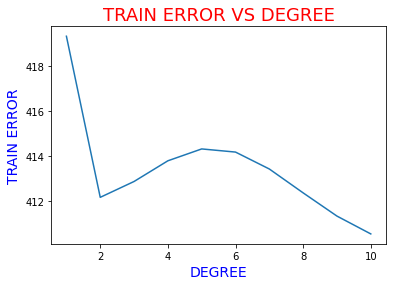

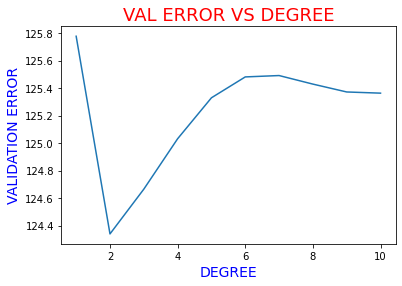

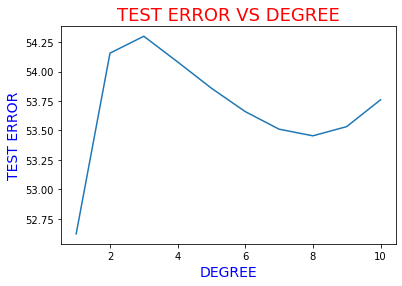

In [105]:
x = [1,2,3,4,5,6,7,8,9,10]
# Train error plot
plt.subplot()
plt.plot(x,train_errors)
plt.xlabel("DEGREE",color = 'blue',fontsize = 14)
plt.ylabel("TRAIN ERROR",color = 'blue',fontsize = 14)
plt.title("TRAIN ERROR VS DEGREE",fontsize = 18,color = 'red')
plt.show()
# Validation error plot
plt.subplot()
plt.plot(x,val_errors)
plt.xlabel("DEGREE",color = 'blue',fontsize = 14)
plt.ylabel("VALIDATION ERROR",color = 'blue',fontsize = 14)
plt.title("VAL ERROR VS DEGREE",fontsize = 18,color = 'red')
plt.show()
# Test error plot
plt.subplot()
plt.plot(x,test_errors)
plt.xlabel("DEGREE",color = 'blue',fontsize = 14)
plt.ylabel("TEST ERROR",color = 'blue',fontsize = 14)
plt.title("TEST ERROR VS DEGREE",fontsize = 18,color = 'red')
plt.show()

# Generating lambda values

In [106]:
# random.seed(69)
# hyperparams = np.random.uniform(0,1,10)
# hyperparams.sort() # to generate the below hyperparameters
# print(hyperparams)
lambda_values = [0.12936004, 0.33442952, 0.33670087, 0.4250879,  0.44624685, 0.47690573, 0.66371102,
               0.73128514, 0.80157154, 0.94589127]

# Finding best lambda values for lasso regression

In [107]:
optimal_lambdas = []
for i in range(10):
    error_val = []
    for lam in lambda_values:
        w = np.zeros((polynomial_coefficients[i].shape[1],1))
        X_train = polynomial_coefficients[i][:train_set_size]
        X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
        weights,error = stoc_grad_descent(w,X_train,y_train,0.0001,print_flag = False,reg = "l1",l_value = lam)
        print("Validation error for degree {} and hyperparameter {} is {}".format(i+1,lam,loss_function(weights,X_val,y_val)))
        error_val.append(loss_function(weights,X_val,y_val))
        print("")
    error_val = np.array(error_val)
    indices = np.argsort(error_val)
    optimal_lambdas.append(lambda_values[indices[0]])

Validation error for degree 1 and hyperparameter 0.12936004 is 125.77946176303863

Validation error for degree 1 and hyperparameter 0.33442952 is 125.78412852131517

Validation error for degree 1 and hyperparameter 0.33670087 is 125.7841802608826

Validation error for degree 1 and hyperparameter 0.4250879 is 125.78619450791889

Validation error for degree 1 and hyperparameter 0.44624685 is 125.78667694679584

Validation error for degree 1 and hyperparameter 0.47690573 is 125.78737616122972

Validation error for degree 1 and hyperparameter 0.66371102 is 125.79164085132228

Validation error for degree 1 and hyperparameter 0.73128514 is 125.79318538628128

Validation error for degree 1 and hyperparameter 0.80157154 is 125.79479295547836

Validation error for degree 1 and hyperparameter 0.94589127 is 125.79809711649361

Validation error for degree 2 and hyperparameter 0.12936004 is 124.3386662435089

Validation error for degree 2 and hyperparameter 0.33442952 is 124.33810517371035

Validat

Validation error for degree 10 and hyperparameter 0.94589127 is 125.33271237645911



In [108]:
optimal_lambdas

[0.12936004,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127,
 0.94589127]

# Polynomial Regression with L1 Regularization (using optimal lambdas)

In [109]:
weights_w_lasso = []
train_errors = []
val_errors = []
test_errors = []
train_RMSE = []
val_RMSE = []
test_RMSE = []

for i in range(10):
    w = np.zeros((polynomial_coefficients[i].shape[1],1))
    X_train = polynomial_coefficients[i][:train_set_size]
    X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
    X_test = polynomial_coefficients[i][train_set_size + val_set_size:]
    print("Lasso regularization model with degree {} and lambda as {}".format(i+1,optimal_lambdas[i]))
    print("Training error every 1000 iterations:")
    weights,error = stoc_grad_descent(w,X_train,y_train,0.0001,print_flag = True,reg = "l1",l_value = optimal_lambdas[i])

    train_errors.append(loss_function(weights,X_train,y_train))
    val_errors.append(loss_function(weights,X_val,y_val))
    test_errors.append(loss_function(weights,X_test,y_test))

    y_train_pred = prediction(weights,X_train)
    y_val_pred = prediction(weights,X_val)
    y_test_pred = prediction(weights,X_test)

    train_RMSE.append(RMSE(y_train,y_train_pred))
    val_RMSE.append(RMSE(y_val,y_val_pred))
    test_RMSE.append(RMSE(y_test,y_test_pred))
    print("")
    weights_w_lasso.append(weights)

Lasso regularization model with degree 1 and lambda as 0.12936004
Training error every 1000 iterations:
475.198609102157
463.11003597233105
453.32101542091107
445.3933743867207
438.9725443296215
433.77158846696113
429.5582877381119
426.14469476618274
423.3786838286544
421.1371151655389

Lasso regularization model with degree 2 and lambda as 0.94589127
Training error every 1000 iterations:
475.198609102157
446.718941862468
431.1165110414926
422.55712784062837
417.8526100628834
415.25994768594177
413.82574342600606
413.0281458799893
412.58124389477746
412.32818869538255

Lasso regularization model with degree 3 and lambda as 0.94589127
Training error every 1000 iterations:
475.198609102157
433.00955851277087
419.5379998223101
415.18830357663126
413.75163419086584
413.254203845815
413.06490175423426
412.97985292608564
412.9320053828619
412.89862090626855

Lasso regularization model with degree 4 and lambda as 0.94589127
Training error every 1000 iterations:
475.198609102157
424.5200592248

In [110]:
for i in range(10):
    print("FOR MODEL WITH DEGREE {} AND LAMBDA {}:".format(i+1,optimal_lambdas[i]))
    print("Train SSE = {}".format(train_errors[i]))
    print("Validation SSE = {}".format(val_errors[i]))
    print("Test SSE = {}".format(test_errors[i]))
    print("Train RMSE = {}".format(train_RMSE[i]))
    print("Validation RMSE = {}".format(val_RMSE[i]))
    print("Test RMSE = {}".format(test_RMSE[i]))
    print(" ")

FOR MODEL WITH DEGREE 1 AND LAMBDA 0.12936004:
Train SSE = 419.3203049797087
Validation SSE = 125.77946176303863
Test SSE = 52.62011356100346
Train RMSE = 0.9465640800542509
Validation RMSE = 0.9706535184640586
Test RMSE = 0.882925386395018
 
FOR MODEL WITH DEGREE 2 AND LAMBDA 0.94589127:
Train SSE = 412.1827799609505
Validation SSE = 124.33653153682721
Test SSE = 54.13109244871687
Train RMSE = 0.9384734603674185
Validation RMSE = 0.9650698351895126
Test RMSE = 0.8955122055848045
 
FOR MODEL WITH DEGREE 3 AND LAMBDA 0.94589127:
Train SSE = 412.8715934770696
Validation SSE = 124.65624733951134
Test SSE = 54.27184065208648
Train RMSE = 0.9392572914629879
Validation RMSE = 0.9663098166319051
Test RMSE = 0.8966756765518956
 
FOR MODEL WITH DEGREE 4 AND LAMBDA 0.94589127:
Train SSE = 413.79264238518977
Validation SSE = 125.02144587843846
Test SSE = 54.0542575783184
Train RMSE = 0.9403043724182436
Validation RMSE = 0.9677242537516378
Test RMSE = 0.8948764249744695
 
FOR MODEL WITH DEGREE 5 A

# Polynomial Regression with ridge regularization

## Finding optimal lambda values

In [111]:
optimal_lambdas = []
for i in range(10):
    error_val = []
    for lam in lambda_values:
        w = np.zeros((polynomial_coefficients[i].shape[1],1))
        X_train = polynomial_coefficients[i][:train_set_size]
        X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
        weights,error = stoc_grad_descent(w,X_train,y_train,0.0001, print_flag = False, reg = "l2", l_value = lam)
        print("Validation error for degree {} and hyperparameter {} is {}".format(i+1,lam,loss_function(weights,X_val,y_val)))
        error_val.append(loss_function(weights,X_val,y_val))
        print("")
    error_val = np.array(error_val)
    indices = np.argsort(error_val)
    optimal_lambdas.append(lambda_values[indices[0]])

Validation error for degree 1 and hyperparameter 0.12936004 is 125.77722392541833

Validation error for degree 1 and hyperparameter 0.33442952 is 125.77833587575572

Validation error for degree 1 and hyperparameter 0.33670087 is 125.7783481924747

Validation error for degree 1 and hyperparameter 0.4250879 is 125.77882749656635

Validation error for degree 1 and hyperparameter 0.44624685 is 125.77894224076837

Validation error for degree 1 and hyperparameter 0.47690573 is 125.77910850528082

Validation error for degree 1 and hyperparameter 0.66371102 is 125.78012162389172

Validation error for degree 1 and hyperparameter 0.73128514 is 125.7804881324044

Validation error for degree 1 and hyperparameter 0.80157154 is 125.78086936724917

Validation error for degree 1 and hyperparameter 0.94589127 is 125.78165220976479

Validation error for degree 2 and hyperparameter 0.12936004 is 124.33904264687418

Validation error for degree 2 and hyperparameter 0.33442952 is 124.33906492127525

Validat

Validation error for degree 10 and hyperparameter 0.94589127 is 125.36281884232562



In [112]:
optimal_lambdas

[0.12936004,
 0.12936004,
 0.94589127,
 0.94589127,
 0.12936004,
 0.12936004,
 0.12936004,
 0.12936004,
 0.12936004,
 0.12936004]

# Polynomial Regression with L2 Regularization (using optimal lambdas)

In [113]:
weights_w_ridge = []
train_errors = []
val_errors = []
test_errors = []
train_RMSE = []
val_RMSE = []
test_RMSE = []

for i in range(10):
    w = np.zeros((polynomial_coefficients[i].shape[1],1))
    X_train = polynomial_coefficients[i][:train_set_size]
    X_val = polynomial_coefficients[i][train_set_size:train_set_size+val_set_size]
    X_test = polynomial_coefficients[i][train_set_size + val_set_size:]
    print("Ridge regularization model with degree {} and lambda as {}".format(i+1,optimal_lambdas[i]))
    print("Training error every 1000 iterations:")
    weights,error = stoc_grad_descent(w,X_train,y_train,0.0001, print_flag = True, reg = "l2", l_value = optimal_lambdas[i])

    train_errors.append(loss_function(weights,X_train,y_train))
    val_errors.append(loss_function(weights,X_val,y_val))
    test_errors.append(loss_function(weights,X_test,y_test))

    y_train_pred = prediction(weights,X_train)
    y_val_pred = prediction(weights,X_val)
    y_test_pred = prediction(weights,X_test)

    train_RMSE.append(RMSE(y_train,y_train_pred))
    val_RMSE.append(RMSE(y_val,y_val_pred))
    test_RMSE.append(RMSE(y_test,y_test_pred))
    print("")
    weights_w_ridge.append(weights)

Ridge regularization model with degree 1 and lambda as 0.12936004
Training error every 1000 iterations:
475.198609102157
463.10456877952726
453.3119141480664
445.3820015775433
438.95989764030554
433.7583880086597
429.5450435993574
426.1317590777279
423.36629079177465
421.12541172375285

Ridge regularization model with degree 2 and lambda as 0.12936004
Training error every 1000 iterations:
475.198609102157
446.63760820108456
431.0118552118679
422.45534539649464
417.7638307835744
415.1866578362617
413.7670721259179
412.9819827496369
412.5452350744722
412.30016466635493

Ridge regularization model with degree 3 and lambda as 0.94589127
Training error every 1000 iterations:
475.198609102157
432.91112104824674
419.45188036781497
415.1293546821007
413.71386940150416
413.2300002691833
413.0487151357037
412.9681966844166
412.9228124534602
412.890699684539

Ridge regularization model with degree 4 and lambda as 0.94589127
Training error every 1000 iterations:
475.198609102157
424.4251217329481


In [114]:
for i in range(10):
    print("FOR MODEL WITH DEGREE {} AND LAMBDA {}:".format(i+1,optimal_lambdas[i]))
    print("Train SSE = {}".format(train_errors[i]))
    print("Validation SSE = {}".format(val_errors[i]))
    print("Test SSE = {}".format(test_errors[i]))
    print("Train RMSE = {}".format(train_RMSE[i]))
    print("Validation RMSE = {}".format(val_RMSE[i]))
    print("Test RMSE = {}".format(test_RMSE[i]))
    print(" ")

FOR MODEL WITH DEGREE 1 AND LAMBDA 0.12936004:
Train SSE = 419.309374230946
Validation SSE = 125.77722392541833
Test SSE = 52.62090335783314
Train RMSE = 0.9465517425625369
Validation RMSE = 0.9706448836098812
Test RMSE = 0.8829320124644735
 
FOR MODEL WITH DEGREE 2 AND LAMBDA 0.12936004:
Train SSE = 412.16090471755905
Validation SSE = 124.33904264687418
Test SSE = 54.15660697922068
Train RMSE = 0.9384485568431219
Validation RMSE = 0.9650795804522024
Test RMSE = 0.8957232292376156
 
FOR MODEL WITH DEGREE 3 AND LAMBDA 0.94589127:
Train SSE = 412.8642673522123
Validation SSE = 124.66412272456321
Test SSE = 54.29792914236099
Train RMSE = 0.9392489581859781
Validation RMSE = 0.966340340339528
Test RMSE = 0.8968911667933934
 
FOR MODEL WITH DEGREE 4 AND LAMBDA 0.94589127:
Train SSE = 413.7823242049632
Validation SSE = 125.03099862692814
Test SSE = 54.08083097384879
Train RMSE = 0.9402926488042009
Validation RMSE = 0.9677612244079768
Test RMSE = 0.8950963612421129
 
FOR MODEL WITH DEGREE 5 A

# Weights list for Degree 2 Polynomial

In [115]:
print("For model of degree 2 and no regularization the weights are {}".format(weights_wo_regu[1]))
print("For model of degree 2 and Lasso regularization the weights are {}".format(weights_w_lasso[1]))
print("For model of degree 2 and Ridge regularization the weights are {}".format(weights_w_ridge[1]))

For model of degree 2 and no regularization the weights are [[0.00990171]
 [0.09639355]
 [0.06559003]
 [0.09537401]
 [0.10350517]
 [0.06441277]]
For model of degree 2 and Lasso regularization the weights are [[0.0098929 ]
 [0.09606354]
 [0.06523207]
 [0.09504848]
 [0.10333649]
 [0.06404406]]
For model of degree 2 and Ridge regularization the weights are [[0.00990158]
 [0.09638629]
 [0.0655853 ]
 [0.09536698]
 [0.10349787]
 [0.06440814]]


# 3D surface plots

### Without regularization

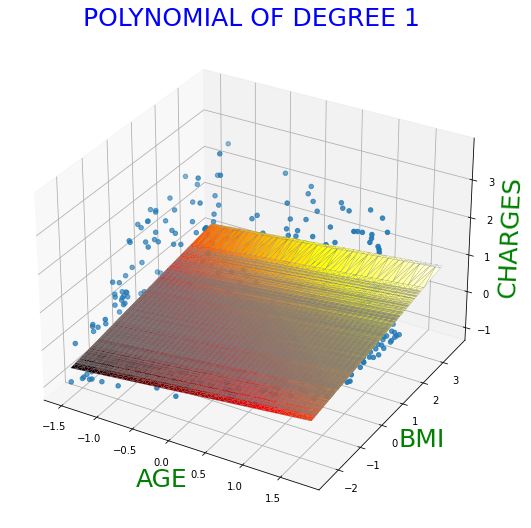

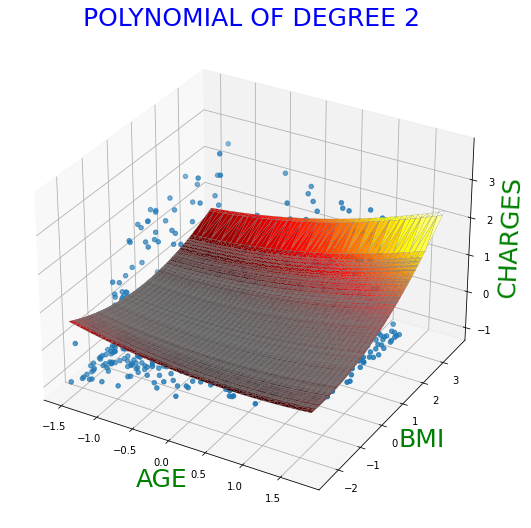

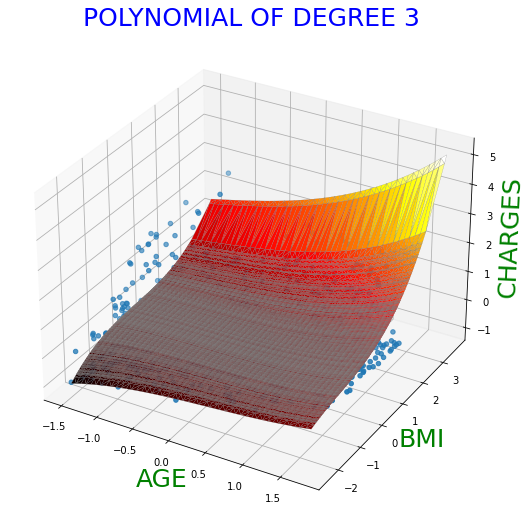

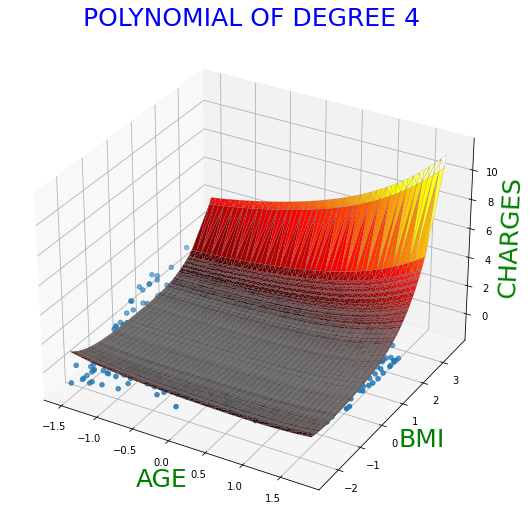

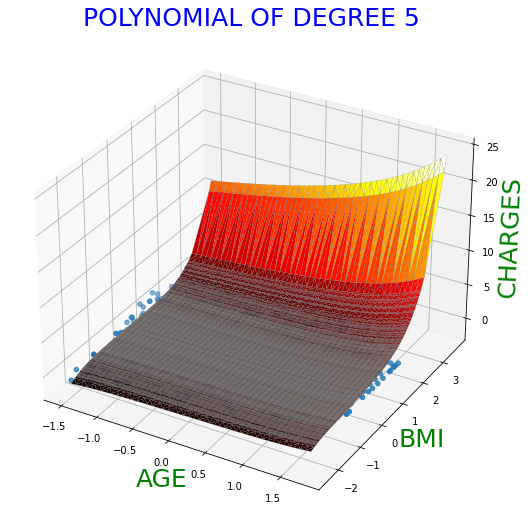

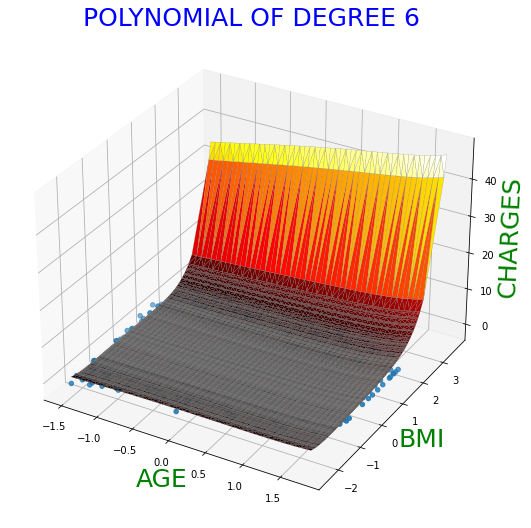

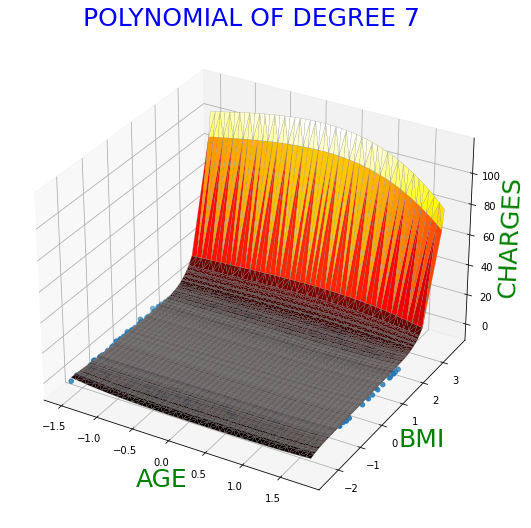

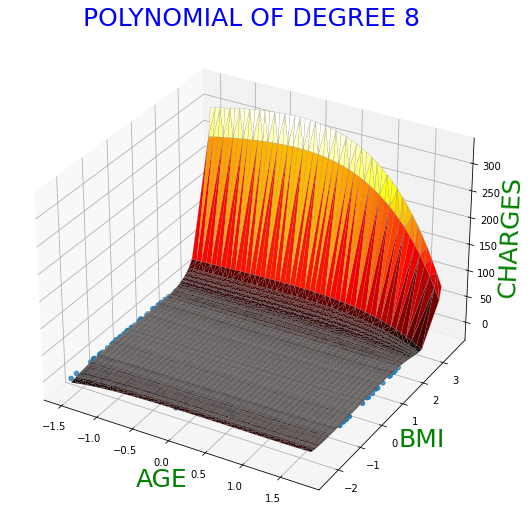

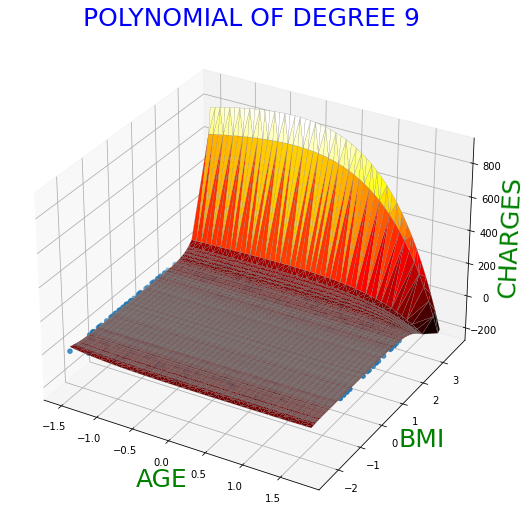

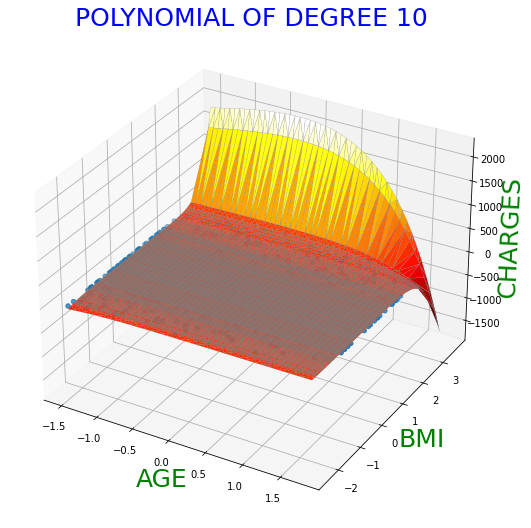

In [116]:
from mpl_toolkits.mplot3d import Axes3D
for i in range(10):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    X = X_train[:][:,1]
    Y = X_train[:][:,2]
    X,Y = np.meshgrid(X, Y)
    X = X.flatten()
    Y = Y.flatten()
    matr = np.array(np.vstack((X, Y)).T,dtype = 'float')
    poly = PolynomialFeatures(i+1)
    data = poly.fit_transform(matr)
    z = prediction(weights_wo_regu[i],data)
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i+1),fontsize=25, color = "Blue")
    ax.set_xlabel('AGE', fontsize=25, color = "green",y=5)
    ax.set_ylabel('BMI',color = "green",fontsize = 25,y=5)
    ax.set_zlabel('CHARGES', fontsize=25,color = "green",y=5)
    my_cmap = plt.get_cmap('hot') 
    ax.scatter(X_train[:][:,1],X_train[:][:,2],y_train, zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    trisurf = ax.plot_trisurf(X, Y, z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    plt.show()

### With lasso regularization

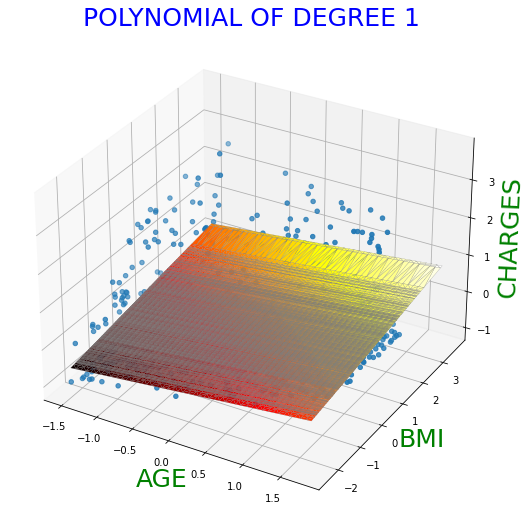

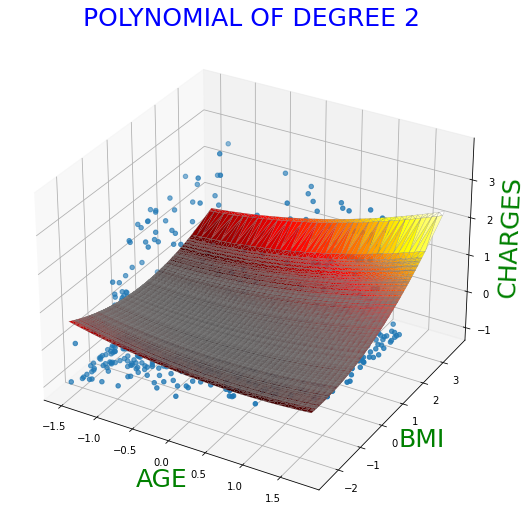

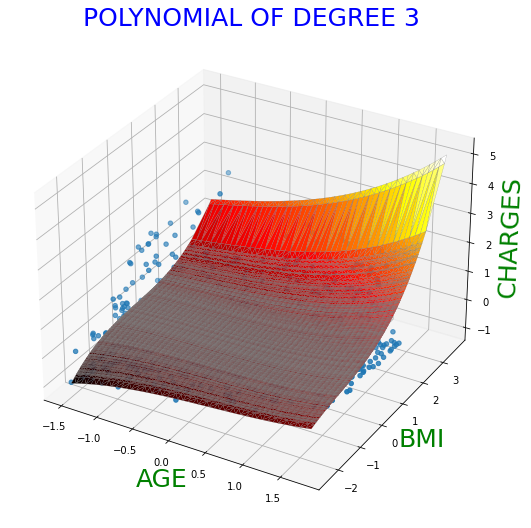

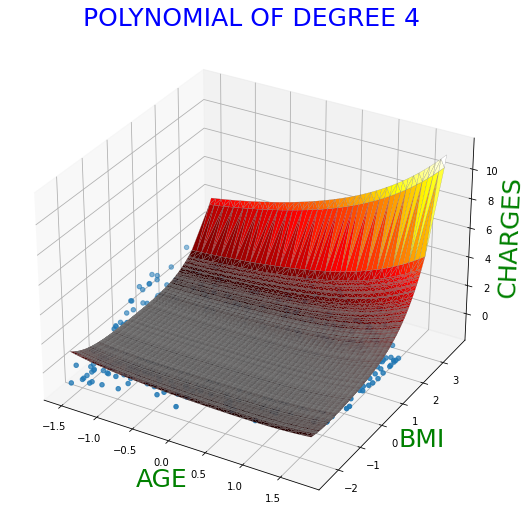

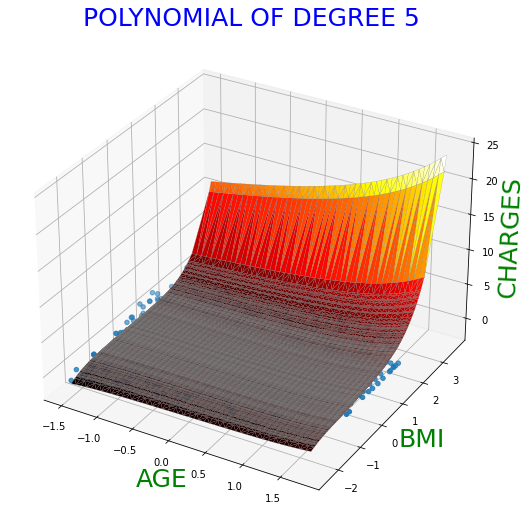

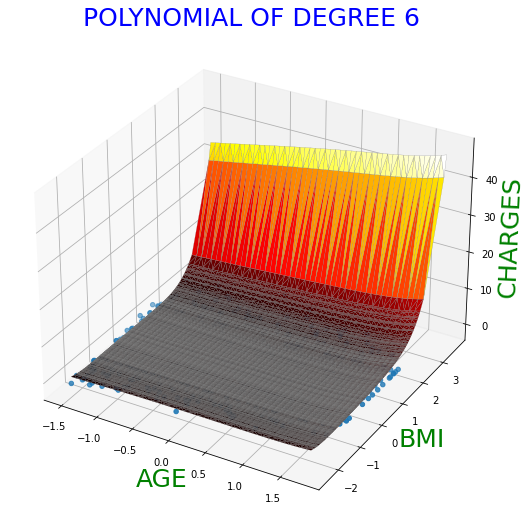

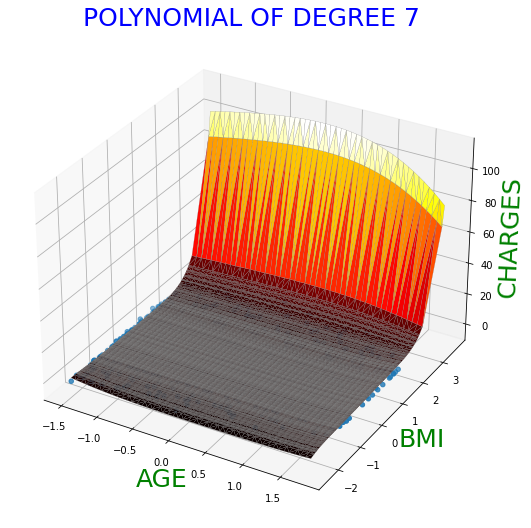

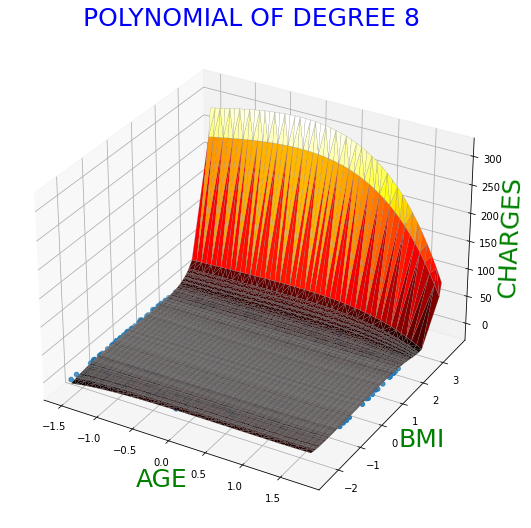

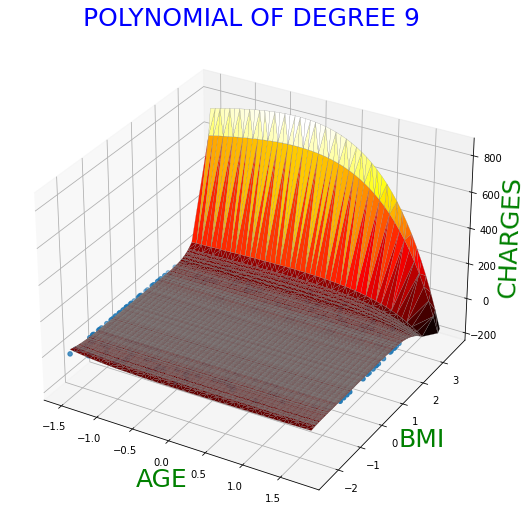

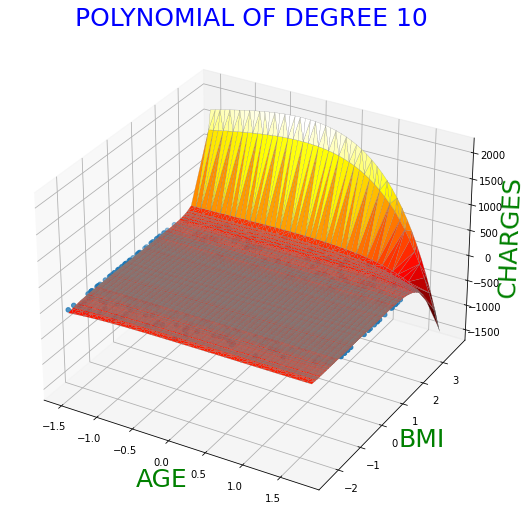

In [117]:
for i in range(10):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    X = X_train[:][:,1]
    Y = X_train[:][:,2]
    X,Y = np.meshgrid(X, Y)
    X = X.flatten()
    Y = Y.flatten()
    matr = np.array(np.vstack((X, Y)).T,dtype = 'float')
    poly = PolynomialFeatures(i+1)
    data = poly.fit_transform(matr)
    z = prediction(weights_w_lasso[i],data)
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i+1),fontsize=25, color = "Blue")
    ax.set_xlabel('AGE', fontsize=25, color = "green",y=5)
    ax.set_ylabel('BMI',color = "green",fontsize = 25,y=5)
    ax.set_zlabel('CHARGES', fontsize=25,color = "green",y=5)
    my_cmap = plt.get_cmap('hot') 
    ax.scatter(X_train[:][:,1],X_train[:][:,2],y_train, zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    trisurf = ax.plot_trisurf(X, Y, z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    plt.show()

### With ridge regularization

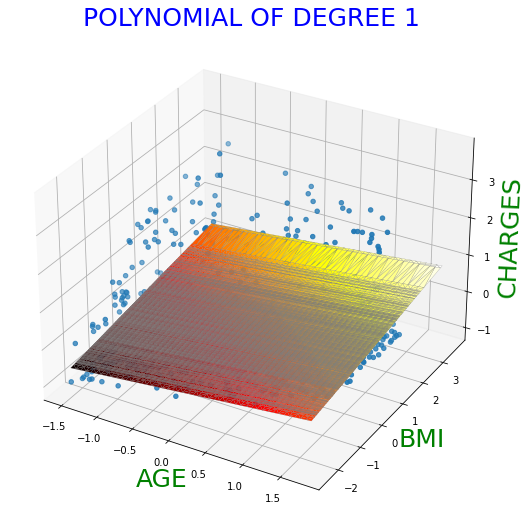

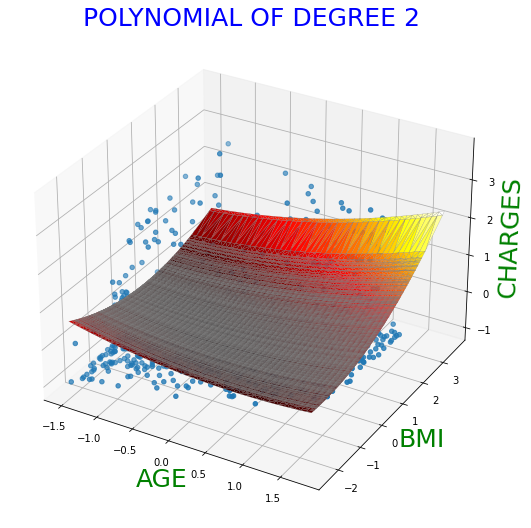

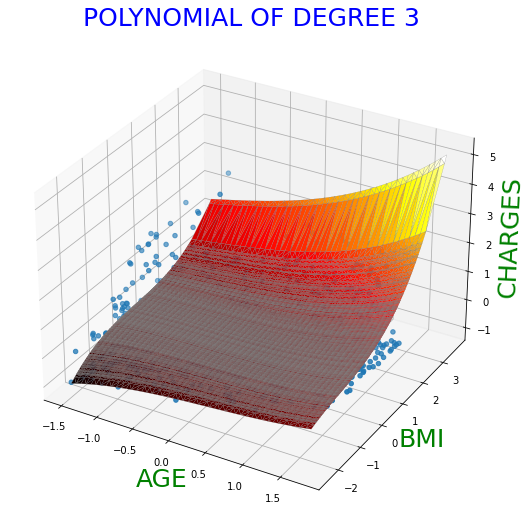

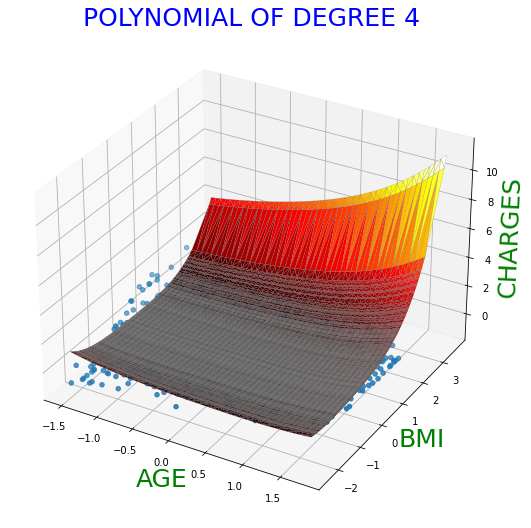

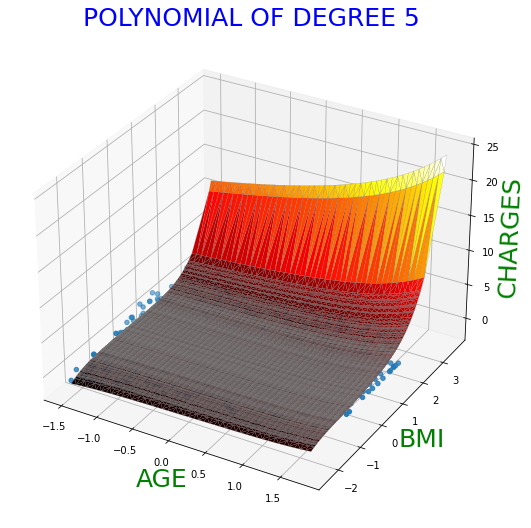

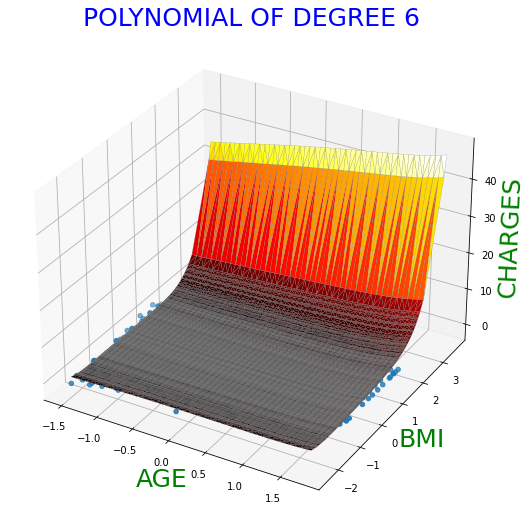

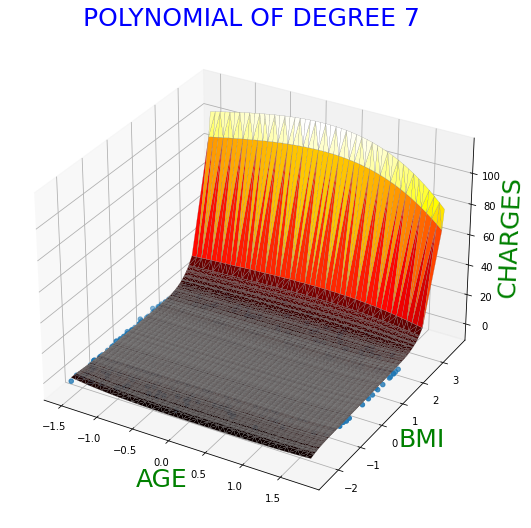

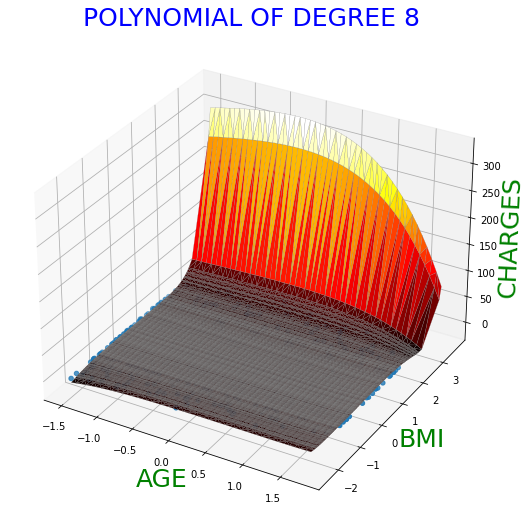

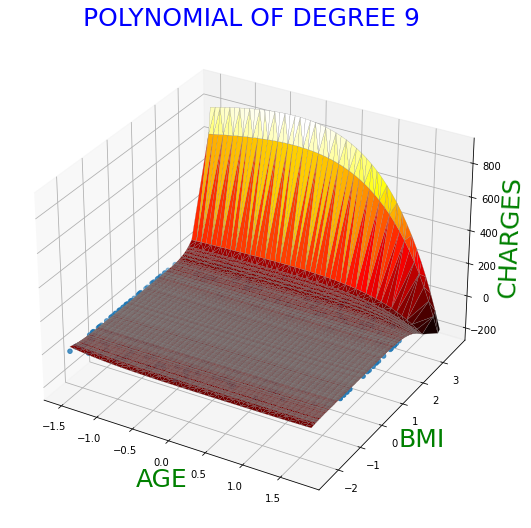

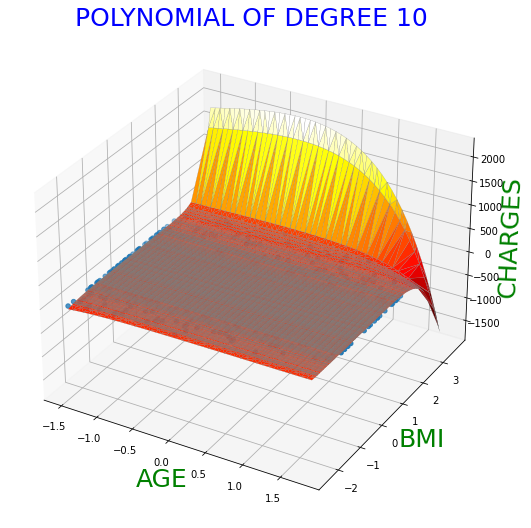

In [118]:
for i in range(10):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    X = X_train[:][:,1]
    Y = X_train[:][:,2]
    X,Y = np.meshgrid(X, Y)
    X = X.flatten()
    Y = Y.flatten()
    matr = np.array(np.vstack((X, Y)).T,dtype = 'float')
    poly = PolynomialFeatures(i+1)
    data = poly.fit_transform(matr)
    z = prediction(weights_w_ridge[i],data)
    ax.set_title('POLYNOMIAL OF DEGREE {}'.format(i+1),fontsize=25, color = "Blue")
    ax.set_xlabel('AGE', fontsize=25, color = "green",y=5)
    ax.set_ylabel('BMI',color = "green",fontsize = 25,y=5)
    ax.set_zlabel('CHARGES', fontsize=25,color = "green",y=5)
    my_cmap = plt.get_cmap('hot') 
    ax.scatter(X_train[:][:,1],X_train[:][:,2],y_train, zdir='z', s=20, c=None, depthshade=True,cmap = my_cmap)
    trisurf = ax.plot_trisurf(X, Y, z.flatten(), cmap = my_cmap,linewidth = 0.2,antialiased = True,edgecolor = 'grey') 
    plt.show()